In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from moviepy.editor import VideoFileClip
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
'''Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.'''
object_points=[]
image_points=[]
objp = np.zeros((6*9,3), np.float32) # 6,9 represents the total number of co-ordinates in y and x direction respectively.
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
# Iterate through the lists and get the corners of the images
#plt.figure(figsize = (16,32)) # To plot the (width, height) in inches
for image in os.listdir("camera_cal/"): # image will iterate through the list of the paths and consider each path one after another 
    img = cv2.imread("camera_cal/" + image) # img stores the data of the image located in the path in the form of numpy array and reads the data of pixel in (BGR) format.    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # gray stres the graysacle img
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None) # Prints the 9*6=54 corners (x,y) co-ordinates.
    # if all the corners are present in the gray(image) the image returns True
    if ret == True :
        object_points.append(objp) #objp are added to the object_points
        image_points.append(corners) # Corners are added to the image_points 
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, gray.shape[::-1], None, None)


In [3]:
def threshold_binary_image(img):
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS) # Converting image from BGR to HLS channel
    s_channel = hls[:,:,2] # Selecting S channel because through trial and error we have seen it give us best results
    h_channel = hls[:,:,0] # Selecting H channel because through trial and error we have seen it give us best results
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Sobel x and Sobel y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 31) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx)) #Rescale to unit 8
    sobely = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in y
    abs_sobely = np.absolute(sobely) # Absolute y derivative to accentuate lines away from horizontal
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely)) #Rescale to unit 8
    # Threshold x gradient and y gradient
    thresh_min = 50
    thresh_max = 150
    sxbinary = np.zeros_like(scaled_sobelx) # Has similar dimensions to the scaled_sobelx but replcaes elements with 0.
    sxbinary[(scaled_sobelx >= 35) & (scaled_sobelx <= thresh_max)] = 1 # Making the points which fall in threshold to 1.
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= thresh_min) & (scaled_sobely <= thresh_max)] = 1    
    # Magnitude of gradient
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 31) # Took kernel size has large has possible because I want to avoid consider the edges which can be clearly seen
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1)  # Took the kernel size has small as possible so that it will be 3 so that it will neglect noises in x direction
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    scaled_sobelm = np.uint8(255*magnitude/np.max(magnitude)) 
    smbinary = np.zeros_like(magnitude) 
    smbinary[(scaled_sobelm >= thresh_min) & (scaled_sobelm <= thresh_max)] = 1 # Create a binary image of ones where threshold is met, zeros otherwise    
    # Direction of the gradient
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 31) # By increasing the size of kenrel we were able to pick up particular points
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = 31) # So I have taken the kernel sixe = 31 which is maximum in this case.
    direction = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    sdbinary =  np.zeros_like(direction)
    sdbinary[(direction >= 0.7) & (direction <= 1.0)] = 1    
    # Compute the combination of Sobel X and Sobel Y or Magnitude and Direction
    sxymd_binary = np.zeros_like(sdbinary)
    sxymd_binary[((sxbinary == 1) & (sybinary == 1)) | ((smbinary == 1) & (sdbinary == 1))] = 1    
    # Threshold color channel
    s_thresh_min = 150
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1    
    # Threshold color channel
    h_thresh_min = 15
    h_thresh_max = 100
    h_binary = np.zeros_like(s_channel)
    h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxymd_binary), sxymd_binary, s_binary)) * 255 
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxymd_binary)
    combined_binary[((s_binary == 1) & (h_binary == 1)) | (sxymd_binary == 1)] = 1   
    return combined_binary

In [4]:
def perspective_transform(img):
    
    width = img.shape[1] # Width of the image
    height = img.shape[0] # Height of the image
    # Points selected on trial and error basis
    src = np.array([[(width*0.4, height*0.665),(width*0.6, height*0.665),(width, height),(0, height)]], dtype=np.float32)
    offset = 200
    dst = np.array([[offset, 0],[width-offset, 0],[width-offset, height], [offset, height]], dtype=np.float32)
    # Perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    # Inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warped output
    warped = cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_LINEAR)
    return Minv, warped
    
    

In [5]:
def detect_lanes(img):

    binary_warped = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take a histogram of the bottom half of the image
    bottom_half_y = binary_warped.shape[0]/2
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds) 
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit,right_fit

In [6]:
def curvature_lane(left_fit, right_fit, image):

    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)    
    # Calculate the new radii of curvature
    left_curve = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curve = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Pixels to meters
    x_max = img.shape[1]*xm_per_pix
    y_max = img.shape[0]*ym_per_pix
    vehicle_center = x_max/2
    # Calculate the vehicle position with respect to center
    center_left = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    center_right = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
    center = center_left + (center_right - center_left)/2
    center_difference = center - vehicle_center
    return left_curve, right_curve, center_difference
   

In [7]:
def warp_original(left_fit, right_fit, Minv, binary_warped, undistorted):
    
    # Create an image to draw the lines on
    binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY)
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    return result

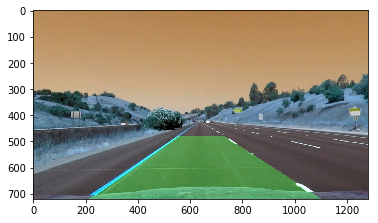

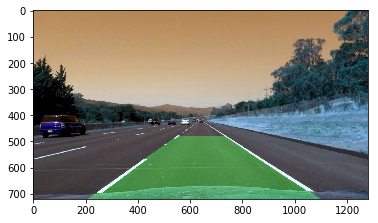

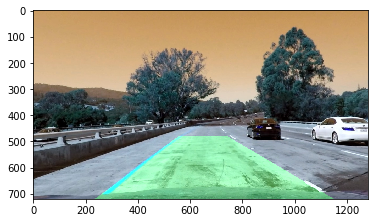

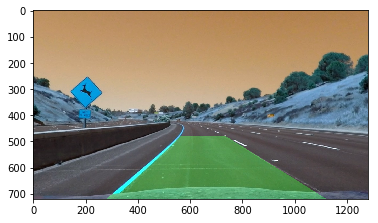

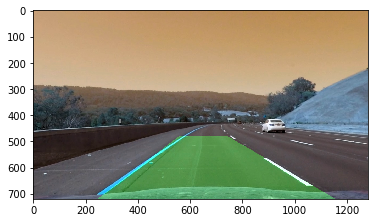

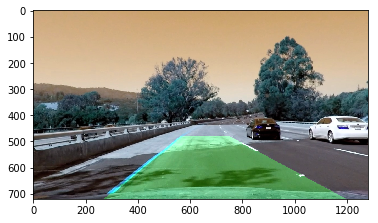

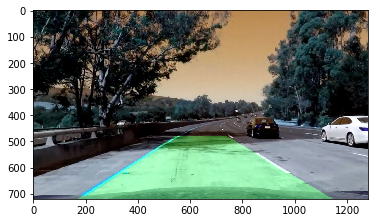

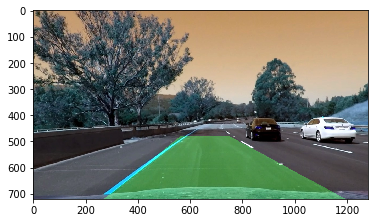

In [8]:
def pipeline(image):
    '''Apply a distortion correction to raw image.'''
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    '''Use color transforms, gradients, etc., to create a thresholded binary image.'''
    combined_binary = threshold_binary_image(undistorted)
    '''Apply a perspective transform to rectify binary image ("birds-eye view").'''
    Minv, warped = perspective_transform(image)
    '''Detect lane pixels and fit to find the lane boundary.'''
    left_fit, right_fit = detect_lanes(warped)
    '''Determine the curvature of the lane and vehicle position with respect to center.'''
    left_curve, right_curve, center_difference = curvature_lane(left_fit, right_fit, warped)
    '''Warp the detected lane boundaries back onto the original image.'''
    final_image = warp_original(left_fit, right_fit, Minv, warped, undistorted)
    # Returning the final image
    return final_image

'''Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position'''
for i in os.listdir("test_images/"):
    image = cv2.imread("test_images/" + i)
    processed_image= pipeline(image)
    plt.imshow(processed_image)
    plt.show()
    cv2.imwrite("output_images/test_images/"+i, processed_image)    
    
    
    
    
    
    

In [9]:
white_output = 'Output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video Output_video.mp4
[MoviePy] Writing video Output_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [18:52<00:00,  1.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output_video.mp4 



In [11]:
white_output = 'Output_challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video Output_challenge_video.mp4
[MoviePy] Writing video Output_challenge_video.mp4


100%|████████████████████████████████████████| 485/485 [08:13<00:00,  1.00s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output_challenge_video.mp4 



In [13]:
white_output = 'Output_harder_challenge_video.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video Output_harder_challenge_video.mp4
[MoviePy] Writing video Output_harder_challenge_video.mp4


100%|█████████████████████████████████████▉| 1199/1200 [51:14<00:00,  1.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output_harder_challenge_video.mp4 

